#1. Persiapan Data & Splitting

In [ ]:
# Install library transformers & datasets (untuk nanti)
!pip install transformers datasets scikit-learn pandas matplotlib seaborn

import pandas as pd
import numpy as np
import os
import re
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

print("Library berhasil diinstall dan diimport.")

Library berhasil diinstall dan diimport.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path_lyrics_folder = '/content/drive/MyDrive/DatasetMirex/Lyrics'

import os
if os.path.exists(path_lyrics_folder):
    print(f"Folder ditemukan di: {path_lyrics_folder}")
    print("Isi folder (sampel):", os.listdir(path_lyrics_folder)[:5])
else:
    print(f"Folder TIDAK ditemukan di {path_lyrics_folder}")
    print("Cek lagi nama folder yang kamu upload di Google Drive.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder ditemukan di: /content/drive/MyDrive/DatasetMirex/Lyrics
Isi folder (sampel): ['003.txt', '019.txt', '015.txt', '008.txt', '020.txt']


In [ ]:
def parse_bat_labels(bat_file_path):
    data_labels = []

    pattern = re.compile(r'move\s+(\d+)\.txt\s+"Cluster\s+(\d+)\\(.+)\\\d+\.txt"')

    with open(bat_file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                song_id = match.group(1)       # Misal: 001
                cluster = int(match.group(2))  # Misal: 1
                category = match.group(3)      # Misal: Boisterous

                data_labels.append({
                    'id': song_id,
                    'filename': f"{song_id}.txt",
                    'cluster': cluster,
                    'label': cluster - 1, # Ubah 1-5 menjadi 0-4 untuk Training
                    'category': category
                })
    return pd.DataFrame(data_labels)

df_info = parse_bat_labels('split-by-categories-lyrics.bat')

print(f"Total label ditemukan: {len(df_info)}")
df_info.head()

Total label ditemukan: 903


,id,filename,cluster,label,category
0,001,001.txt,1,0,Boisterous
1,002,002.txt,1,0,Boisterous
2,003,003.txt,1,0,Boisterous
3,004,004.txt,1,0,Boisterous
4,005,005.txt,1,0,Boisterous


In [ ]:
import os

def load_lyrics_final(df, root_folder):
    texts = []
    found_count = 0
    missing_count = 0

    # 1. Buat Peta Lokasi File (Agar pencarian cepat)
    print(f"Sedang memindai file di: {root_folder} ...")
    file_map = {}
    for root, dirs, files in os.walk(root_folder):
        for file in files:
            # Kita simpan nama file dalam huruf kecil agar tidak sensitif huruf besar/kecil
            file_map[file.lower()] = os.path.join(root, file)

    print(f"Total file fisik ditemukan: {len(file_map)}")

    # 2. Mulai mencocokkan dengan Daftar Label (.bat)
    for _, row in df.iterrows():
        target_file = row['filename'].lower() # Misal: '001.txt'

        if target_file in file_map:
            full_path = file_map[target_file]
            content = ""

            # Strategi Membaca File (Anti-Gagal Encoding)
            try:
                with open(full_path, 'rb') as f:
                    raw_data = f.read()

                    # Coba 1: UTF-8 (Standar)
                    try:
                        content = raw_data.decode('utf-8')
                    except:
                        # Coba 2: CP1252 (Windows)
                        try:
                            content = raw_data.decode('cp1252')
                        except:
                            # Coba 3: Latin-1 (Pasti bisa baca, walau ada karakter aneh)
                            content = raw_data.decode('latin-1', errors='ignore')

                # Cek apakah isinya kosong
                if len(content.strip()) > 0:
                    texts.append(content.strip())
                    found_count += 1
                else:
                    texts.append("") # File ada tapi kosong
                    missing_count += 1

            except Exception as e:
                print(f"Error membaca {target_file}: {e}")
                texts.append("")
                missing_count += 1
        else:
            # File benar-benar tidak ada di folder
            texts.append("")
            missing_count += 1

    df['text'] = texts
    print(f"-" * 30)
    print(f"Berhasil load teks : {found_count}")
    print(f"Gagal/Tidak ada    : {missing_count}")
    return df


df_dataset = load_lyrics_final(df_info, path_lyrics_folder)

# Buang data yang kosong
df_dataset = df_dataset[df_dataset['text'] != ""]
print(f"Total Data Bersih Siap Training: {len(df_dataset)}")

# Intip datanya
df_dataset.head()

Sedang memindai file di: /content/drive/MyDrive/DatasetMirex/Lyrics ...
Total file fisik ditemukan: 709
------------------------------
Berhasil load teks : 709
Gagal/Tidak ada    : 194
Total Data Bersih Siap Training: 709


,id,filename,cluster,label,category,text
0,001,001.txt,1,0,Boisterous,Mama he treats your daughter mean \r\nMama he ...
2,003,003.txt,1,0,Boisterous,I plopped down in my easy chair and turned on ...
3,004,004.txt,1,0,Boisterous,Back in black \r\nI hit the sack \r\nIt's been...
6,007,007.txt,1,0,Boisterous,"Woo, I gave you my money, I gave you my time.\..."
7,008,008.txt,1,0,Boisterous,Is it my imagination \r\nOr have I finally fou...


Jumlah Train: 567
Jumlah Val  : 71
Jumlah Test : 71


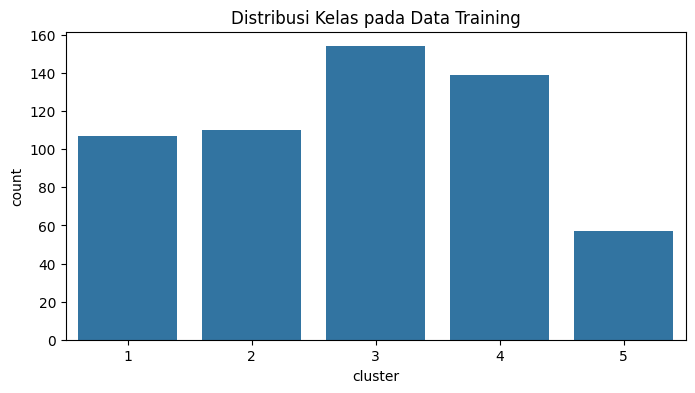

In [ ]:
train_val, test = train_test_split(
    df_dataset,
    test_size=0.1,
    stratify=df_dataset['label'], # Stratify agar proporsi Cluster seimbang
    random_state=42
)

train, val = train_test_split(
    train_val,
    test_size=0.1111,
    stratify=train_val['label'],
    random_state=42
)

print(f"Jumlah Train: {len(train)}")
print(f"Jumlah Val  : {len(val)}")
print(f"Jumlah Test : {len(test)}")

# Visualisasi Distribusi (Untuk Laporan Poin 1)
plt.figure(figsize=(8,4))
sns.countplot(x='cluster', data=train)
plt.title("Distribusi Kelas pada Data Training")
plt.show()

In [ ]:
# Cek selisih data
total_di_bat = len(df_info)
total_yang_dipakai = len(df_dataset)
missing_count = total_di_bat - total_yang_dipakai

print(f"Total ID di file .bat : {total_di_bat}")
print(f"Total yang punya lirik: {total_yang_dipakai}")
print(f"Selisih (Dibuang)     : {missing_count} data")

# Lihat 5 ID pertama yang dibuang
all_ids = set(df_info['id'])
used_ids = set(df_dataset['id'])
missing_ids = list(all_ids - used_ids)

print("\n5 Contoh ID yang dibuang (Missing/Empty):")
print(missing_ids[:5])

# Cek alasan kenapa ID pertama dibuang
if len(missing_ids) > 0:
    sample_id = missing_ids[0]
    sample_file = f"{sample_id}.txt"
    print(f"\nAnalisis sample hilang ({sample_file}):")

    # Cari path file ini
    found = False
    for root, dirs, files in os.walk(extract_path):
        if sample_file in files:
            file_path = os.path.join(root, sample_file)
            size = os.path.getsize(file_path)
            print(f"-> File DITEMUKAN di {file_path}")
            print(f"-> Ukuran File: {size} bytes")
            if size == 0:
                print("-> ALASAN: File kosong (0 bytes/Instrumental).")
            else:
                print("-> ALASAN: File ada isinya tapi mungkin gagal dibaca (encoding).")
            found = True
            break

    if not found:
        print("-> ALASAN: File TIDAK DITEMUKAN sama sekali di folder ZIP.")

Total ID di file .bat : 903
Total yang punya lirik: 709
Selisih (Dibuang)     : 194 data

5 Contoh ID yang dibuang (Missing/Empty):
['265', '850', '854', '095', '006']

Analisis sample hilang (265.txt):
-> ALASAN: File TIDAK DITEMUKAN sama sekali di folder ZIP.


# 2.Tokenisasi & Dataset Class

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

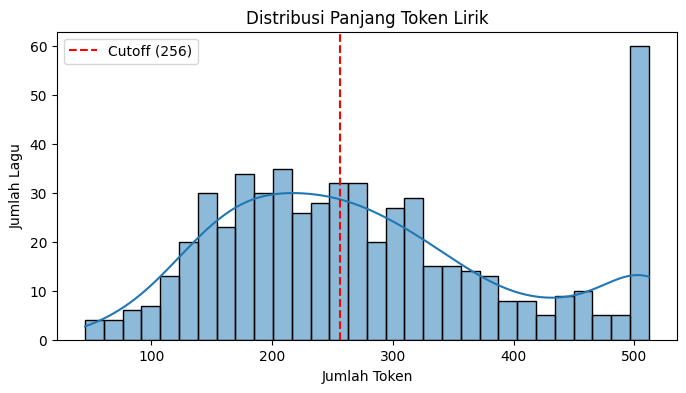

Rata-rata panjang token: 279
Max panjang token: 512


In [ ]:
from transformers import BertTokenizer

# 1. Load Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 2. Cek Distribusi Panjang Token (Untuk Laporan: Preprocessing)
# Kita ambil sampel dari data train untuk melihat seberapa panjang liriknya
token_lens = []

for txt in train['text']:
    # Encode teks menjadi token ID tanpa pemotongan dulu untuk melihat panjang aslinya
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

# Visualisasi
plt.figure(figsize=(8, 4))
sns.histplot(token_lens, bins=30, kde=True)
plt.title("Distribusi Panjang Token Lirik")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Lagu")
plt.axvline(x=256, color='r', linestyle='--', label='Cutoff (256)')
plt.legend()
plt.show()

print(f"Rata-rata panjang token: {int(np.mean(token_lens))}")
print(f"Max panjang token: {max(token_lens)}")

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,    # Tambah [CLS] dan [SEP]
            max_length=self.max_len,    # Batas panjang
            return_token_type_ids=False,
            padding='max_length',       # Pad (isi 0) sampai max_length
            truncation=True,            # Potong jika kepanjangan
            return_attention_mask=True, # Return attention mask
            return_tensors='pt',        # Return PyTorch tensors
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Class LyricsDataset berhasil dibuat.")

Class LyricsDataset berhasil dibuat.


In [ ]:
MAX_LEN = 256
BATCH_SIZE = 16

# 1. Buat Instance Dataset
train_dataset = LyricsDataset(
    texts=train['text'].to_numpy(),
    labels=train['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_dataset = LyricsDataset(
    texts=val['text'].to_numpy(),
    labels=val['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

test_dataset = LyricsDataset(
    texts=test['text'].to_numpy(),
    labels=test['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# 2. Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False) # Val jangan di-shuffle
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False) # Test jangan di-shuffle agar urutan ID tetap

print(f"Data Loader Siap!")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Contoh satu batch data:")
data = next(iter(train_loader))
print(f"Input IDs shape: {data['input_ids'].shape}") # Harusnya [16, 256]
print(f"Labels shape: {data['labels'].shape}")       # Harusnya [16]

Data Loader Siap!
Batch Size: 16
Contoh satu batch data:
Input IDs shape: torch.Size([16, 256])
Labels shape: torch.Size([16])


#3. Training & Evaluasi

In [ ]:
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW

# 1. Setup Device (Gunakan GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {device}")

# 2. Load Model Pre-trained
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=5 # Ada 5 Cluster
)
model = model.to(device) # Pindahkan model ke GPU

# 3. Setup Optimizer & Scheduler
EPOCHS = 10
# Catatan: Learning rate 2e-5 adalah standar emas untuk BERT
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Fungsi untuk menghitung akurasi (Helper)
def calculate_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

print("Model berhasil di-load ke GPU.")

Menggunakan device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil di-load ke GPU.


In [ ]:
import time

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train() # Mode latihan
    losses = []
    accuracies = []

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["labels"].to(device)

        # 1. Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets
        )

        loss = outputs.loss
        logits = outputs.logits

        # 2. Simpan stats
        losses.append(loss.item())

        # Hitung akurasi batch ini
        preds = logits.detach().cpu().numpy()
        labels = targets.detach().cpu().numpy()
        accuracies.append(calculate_accuracy(preds, labels))

        # 3. Backward pass (Update bobot)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Mencegah gradient meledak
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses), np.mean(accuracies)

def eval_model(model, data_loader, device):
    model = model.eval() # Mode evaluasi (matikan dropout)
    losses = []
    accuracies = []

    with torch.no_grad(): # Tidak perlu hitung gradien (hemat memori)
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets
            )

            loss = outputs.loss
            logits = outputs.logits

            losses.append(loss.item())

            preds = logits.detach().cpu().numpy()
            labels = targets.detach().cpu().numpy()
            accuracies.append(calculate_accuracy(preds, labels))

    return np.mean(losses), np.mean(accuracies)

In [ ]:
history = {
    'train_acc': [], 'train_loss': [],
    'val_acc': [], 'val_loss': []
}

print("Mulai Training...")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    # Training
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # Validasi
    val_loss, val_acc = eval_model(model, val_loader, device)
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print()

    # Simpan history untuk grafik
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

print("Training Selesai!")

Mulai Training...
Epoch 1/10
----------
Train Loss: 1.5827 | Train Acc: 0.2711
Val   Loss: 1.5224 | Val   Acc: 0.2821

Epoch 2/10
----------
Train Loss: 1.4435 | Train Acc: 0.4286
Val   Loss: 1.4377 | Val   Acc: 0.4482

Epoch 3/10
----------
Train Loss: 1.2526 | Train Acc: 0.5439
Val   Loss: 1.4064 | Val   Acc: 0.4214

Epoch 4/10
----------
Train Loss: 1.0488 | Train Acc: 0.6466
Val   Loss: 1.4105 | Val   Acc: 0.4214

Epoch 5/10
----------
Train Loss: 0.8447 | Train Acc: 0.7560
Val   Loss: 1.4894 | Val   Acc: 0.3893

Epoch 6/10
----------
Train Loss: 0.6410 | Train Acc: 0.8341
Val   Loss: 1.5193 | Val   Acc: 0.3929

Epoch 7/10
----------
Train Loss: 0.4746 | Train Acc: 0.9040
Val   Loss: 1.5560 | Val   Acc: 0.3857

Epoch 8/10
----------
Train Loss: 0.3628 | Train Acc: 0.9370
Val   Loss: 1.6174 | Val   Acc: 0.4179

Epoch 9/10
----------
Train Loss: 0.2836 | Train Acc: 0.9705
Val   Loss: 1.6615 | Val   Acc: 0.3768

Epoch 10/10
----------
Train Loss: 0.2457 | Train Acc: 0.9757
Val   Loss:

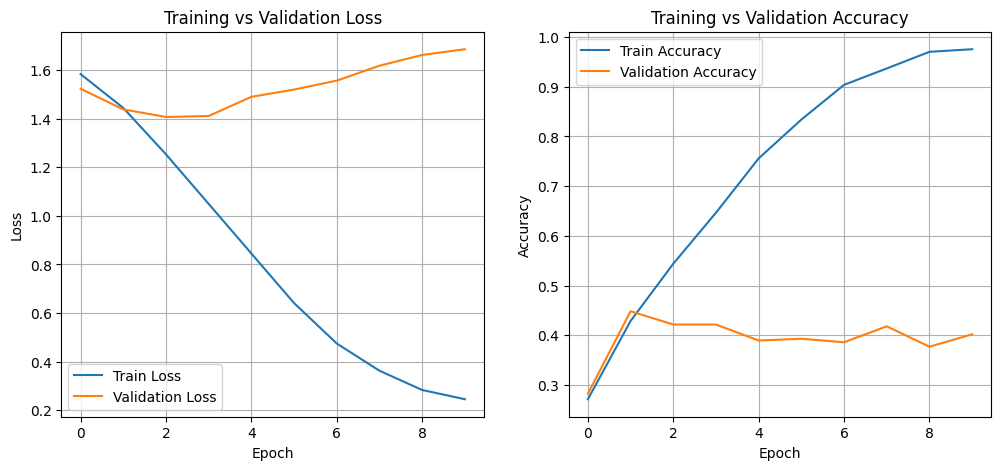

In [ ]:
# Plot Learning Curve
plt.figure(figsize=(12, 5))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Grafik Akurasi
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# 4. Evaluasi Detail pada Test Set

              precision    recall  f1-score   support

   Cluster 1       0.27      0.21      0.24        14
   Cluster 2       0.42      0.57      0.48        14
   Cluster 3       0.67      0.53      0.59        19
   Cluster 4       0.52      0.65      0.58        17
   Cluster 5       0.00      0.00      0.00         7

    accuracy                           0.45        71
   macro avg       0.38      0.39      0.38        71
weighted avg       0.44      0.45      0.44        71



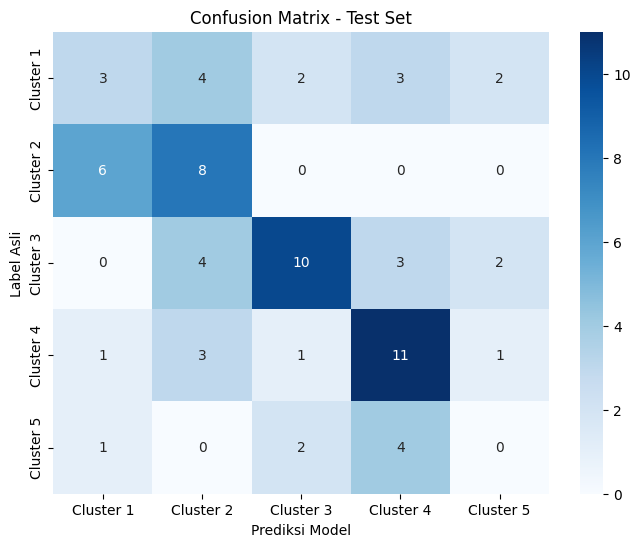

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn.functional as F

def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            # Ambil probabilitas dengan Softmax
            probs = F.softmax(outputs.logits, dim=1)

            _, preds = torch.max(outputs.logits, dim=1)

            predictions.extend(preds.tolist())
            prediction_probs.extend(probs.tolist())
            real_values.extend(targets.tolist())

    return predictions, prediction_probs, real_values

# Ambil prediksi dari Test Set
y_pred, y_probs, y_test = get_predictions(model, test_loader)

# 1. Print Laporan Klasifikasi (Precision, Recall, F1)
class_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
print(classification_report(y_test, y_pred, target_names=class_names))

# 2. Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [ ]:
test_df_analysis = test.copy().reset_index(drop=True)
test_df_analysis['pred'] = y_pred
test_df_analysis['true'] = y_test

# Fungsi print format rapi
def print_examples(df_subset, title):
    print(f"--- {title} ---")
    for idx, row in df_subset.head(2).iterrows(): # Ambil 2 contoh saja
        print(f"ID Lagu: {row['id']}")
        print(f"Label Asli : Cluster {row['true'] + 1}")
        print(f"Prediksi   : Cluster {row['pred'] + 1}")
        print(f"Cuplikan Lirik: {row['text'][:150]}...") # Print 150 huruf awal
        print("-" * 30)

# 1. Contoh Sukses (Benar)
success_cases = test_df_analysis[test_df_analysis['pred'] == test_df_analysis['true']]
print_examples(success_cases, "CONTOH SUKSES (Model Benar)")

print("\n")

# 2. Contoh Gagal (Salah)
failure_cases = test_df_analysis[test_df_analysis['pred'] != test_df_analysis['true']]
print_examples(failure_cases, "CONTOH GAGAL (Model Salah)")

--- CONTOH SUKSES (Model Benar) ---
ID Lagu: 479
Label Asli : Cluster 3
Prediksi   : Cluster 3
Cuplikan Lirik: The phone don't ring
And the sun refused to shine
Never thought I'd have to pay so dearly
For what was already mine
For such a long, long time

...
------------------------------
ID Lagu: 090
Label Asli : Cluster 1
Prediksi   : Cluster 1
Cuplikan Lirik: I'm ready, ready as anybody can be
I'm ready, ready as anybody can be
Now I'm ready for you, I hope you're ready for me

I got an axe handle pisto...
------------------------------


--- CONTOH GAGAL (Model Salah) ---
ID Lagu: 771
Label Asli : Cluster 5
Prediksi   : Cluster 4



Got high heel sneakers and an alligator h...
------------------------------
ID Lagu: 202
Label Asli : Cluster 2
Prediksi   : Cluster 1
Cuplikan Lirik: Cowboys ain't easy to love and they're harder to hold
They'd rather give you a song than diamonds or gold
Lonestar belt buckles and old faded levis ...
------------------------------


In [ ]:
# Buat DataFrame hasil probabilitas
probs_df = pd.DataFrame(y_probs, columns=[f'prob_cluster_{i+1}' for i in range(5)])

# Gabungkan dengan ID lagu
final_output = pd.DataFrame()
final_output['id'] = test_df_analysis['id']
final_output = pd.concat([final_output, probs_df], axis=1)
final_output['true_label'] = test_df_analysis['true'] # Simpan label asli buat cek nanti

# Simpan ke CSV
final_output.to_csv('lyrics_prediction_probabilities.csv', index=False)

print("File 'lyrics_prediction_probabilities.csv' berhasil disimpan!")
print(final_output.head())

File 'lyrics_prediction_probabilities.csv' berhasil disimpan!
    id  prob_cluster_1  prob_cluster_2  prob_cluster_3  prob_cluster_4  \
0  771        0.067417        0.084458        0.031844        0.651652   
1  479        0.028188        0.007549        0.895131        0.024240   
2  090        0.824380        0.061425        0.022455        0.025503   
3  212        0.121313        0.835450        0.010555        0.023039   
4  155        0.817198        0.116179        0.013579        0.015924   

   prob_cluster_5  true_label  
0        0.164629           4  
1        0.044892           2  
2        0.066236           0  
3        0.009643           1  
4        0.037120           0  
